In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scapy.utils
from scapy.layers.inet import IP, UDP
import sigmf
from sigmf import SigMFFile

from lte import *

plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (7, 3.5)

In [2]:
wireshark_udp_packets = []

# Format as UDP frame for wireshark
def mac_pdu_to_udp(subframe, mac_pdu, rnti, ce_mode=0, direction=1, nb_mode=0):
    udp_mac_pdu = b'mac-lte'
    radio_type = 1  # FDD
    # direction = 1 is downlink
    if rnti == None:
        rnti_type = 0  # PBCH (NO_RNTI)
    elif rnti == 0xffff:
        rnti_type = 4  # SI-RNTI
    elif rnti == 0xfffe:
        rnti_type = 1  # P-RNTI
    else:
        rnti_type = 3  # C-RNTI
    # The -1 is because subframe=0 corresponds
    # to the subframe imediately before of the first
    # PBCH.
    s = subframe
    s = (((s // 10) << 4) | (s % 10)) & 0xffff
    payload_tag = 0x1    
    rnti_tag = 0x2
    ueid_tag = 0x3
    subframe_tag = 0x4
    ce_mode_tag = 0xe
    nb_mode_tag = 0xf
    udp_mac_pdu += bytes([radio_type, direction, rnti_type])
    if rnti is not None:
        udp_mac_pdu += bytes([rnti_tag, rnti >> 8, rnti & 0xff])
    if rnti_type == 3:
        # use C-RNTI as UE ID, since we don't have anything better
        udp_mac_pdu += bytes([ueid_tag, rnti >> 8, rnti & 0xff])
    udp_mac_pdu += bytes([subframe_tag, s >> 8, s & 0xff])
    udp_mac_pdu += bytes([ce_mode_tag, ce_mode & 0xff])
    udp_mac_pdu += bytes([nb_mode_tag, nb_mode & 0xff])
    udp_mac_pdu += bytes([payload_tag])
    udp_mac_pdu += mac_pdu
    return udp_mac_pdu

def store_mac_pdu(subframe, mac_pdu, rnti):
    packet = (IP(src='127.0.0.1', dst='127.0.0.1')
              / UDP(sport=9999, dport=9999)
              / mac_pdu_to_udp(subframe, mac_pdu, rnti, direction=0, nb_mode=1))
    packet.time = (t_syms[14*subframe] * 1e9 * np.timedelta64(1, 'ns')
                   + np.datetime64('2025-11-15T17:34:32.232')
                   - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
    wireshark_udp_packets.append(packet)

In [3]:
dataset_path = 'V16-beacon-NB-IoT-uplink.sigmf-meta'
dataset = sigmf.sigmffile.fromfile(dataset_path)
fs_sigmf = dataset.get_global_field(SigMFFile.SAMPLE_RATE_KEY)
f_center = dataset.get_capture_info(0)[SigMFFile.FREQUENCY_KEY]
annotations = dataset.get_annotations()
GENERATOR = 'destevez Jupyter notebook'
# remove annotations introduced by this notebook
annotations = [a for a in annotations if a[SigMFFile.GENERATOR_KEY] != GENERATOR]
dataset._metadata[SigMFFile.ANNOTATION_KEY] = annotations

In [4]:
fs = 1920000

x = np.fromfile('V16-beacon-NB-IoT-uplink-1920ksps.c64', 'complex64')
t_x = np.arange(x.size) / fs

# Scale amplitude so that the PUSCH QPSK symbols are (+/-1 +/-1j)/sqrt(2)
x = x / 2.16
# Correct for CFO. The CFO is measured with the PUSCH and DMRS.
delta_f = 25779.5

x *= np.exp(1j*2*np.pi*delta_f/fs*np.arange(x.size))

In [5]:
nominal_uplink_freq = 832.3e6
f_center - delta_f - nominal_uplink_freq

18346.5

In [6]:
# The units here are samples
Tu = 128 # useful time of a symbol
cp_len = 9  # 4.7 usecs, used in symbols 1-6 in a slot
cp_len2 = 10  # 5.2 usecs, used in symbol 0 in a slot

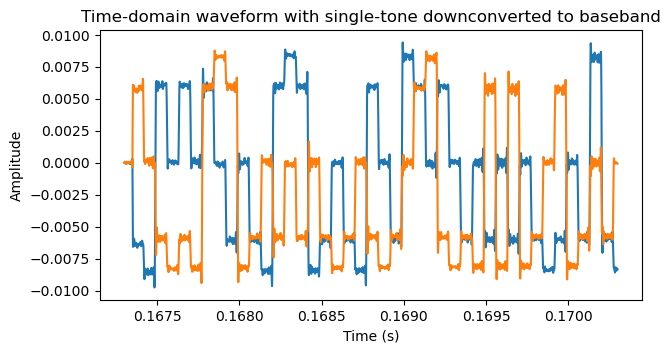

In [7]:
sel = slice(round(0.1673 * fs), round(0.1703 * fs))
y = x[sel] * np.exp(-1j*2*np.pi*(15e3 + 7.5e3 - 23.3)/fs*np.arange(x[sel].size))
plt.plot(t_x[sel], y.real)
plt.plot(t_x[sel], y.imag)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time-domain waveform with single-tone downconverted to baseband');

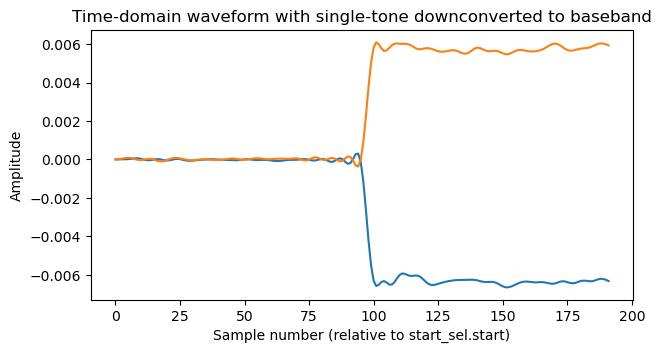

In [8]:
start_sel = slice(round(0.1673 * fs), round(0.1674 * fs))
y = x[start_sel] * np.exp(-1j*2*np.pi*(15e3 + 7.5e3 - 23.3)/fs*np.arange(x[start_sel].size))
plt.plot(y.real)
plt.plot(y.imag)
plt.xlabel('Sample number (relative to start_sel.start)')
plt.ylabel('Amplitude')
plt.title('Time-domain waveform with single-tone downconverted to baseband');

In [9]:
a0 = start_sel.start + 93

In [10]:
occupied_subcarriers = np.arange(-6, 6) + Tu//2

# Here we take into account the 7.5 kHz shift of the uplink
# subcarriers
freq_syms = 7.5e3 + np.fft.fftshift(np.fft.fftfreq(Tu, 1/fs))
freq_syms = freq_syms[occupied_subcarriers]

def ofdm_demodulate(a0, freq_error):
    y = x * np.exp(1j*2*np.pi*freq_error/fs*np.arange(x.size))
    slots = (x.size - a0) // (fs // 1000) * 2
    nsymbols = slots * 7
    # Extract symbols: PUSCH is handled as SC-OFDM, while DMRS is plain OFDM
    ofdm_syms = np.empty((nsymbols, occupied_subcarriers.size), 'complex64')
    intrasym_freq = np.empty(nsymbols)
    t_syms = np.empty(nsymbols)
    for j in range(nsymbols):
        # For each slot, we need to advance cp_len2-cp_len because of the
        # longer cyclic prefix of the first symbol in each slot. delta counts
        # this.
        delta = (cp_len2 - cp_len) * (j//7)    
        start_sample = a0 + j * (Tu + cp_len) + delta
        t_syms[j] = start_sample / fs
    
        # Before performing the FFT, we multiply by an exponential to cancel out the 7.5 kHz shift of
        # the symbols. The phase of this exponential is zero at the start of the symbol.
        syms = np.fft.fftshift(np.fft.fft(y[start_sample:][:Tu] * np.exp(-1j*np.pi*np.arange(Tu)/Tu)))
        ofdm_syms[j] = syms[occupied_subcarriers]

        # Frequency estimator using intra-symbol data (only valid for single-tone SC-FDMA)
        intrasym_freq[j] = np.angle(np.sum(y[start_sample+Tu//2:][:Tu//2]
                                           * np.conjugate(y[start_sample:][:Tu//2]))) / (2 * np.pi * Tu//2) * fs
    return t_syms, ofdm_syms, intrasym_freq

In [11]:
t_syms, ofdm_syms, intrasym_freq = ofdm_demodulate(start_sel.start + 93, 23.3)

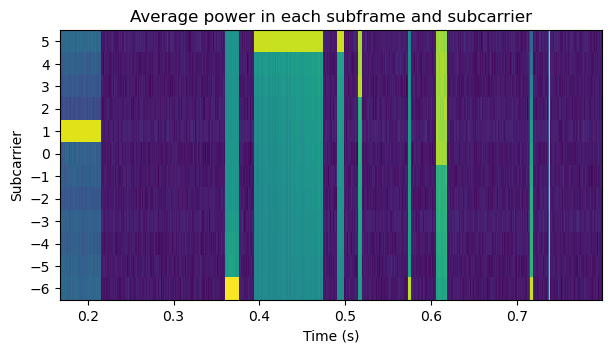

In [12]:
subframe_raster = np.average((np.abs(ofdm_syms)**2).reshape(-1, 14, 12), axis=1)
plt.imshow(10*np.log10(subframe_raster).T[::-1], aspect='auto', interpolation='none',
           extent=[t_syms[0], t_syms[::14][-1]+1e-3, -6.5, 5.5])
plt.yticks(np.arange(-6, 6))
plt.ylabel('Subcarrier')
plt.xlabel('Time (s)')
plt.title('Average power in each subframe and subcarrier');

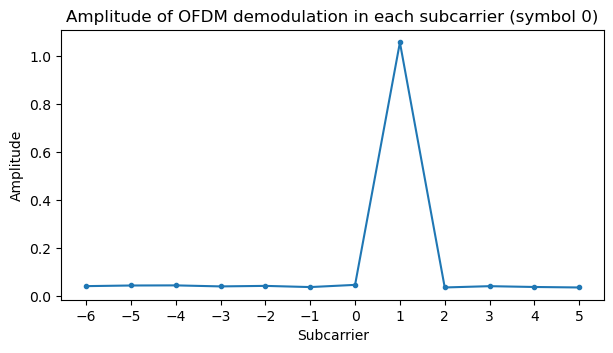

In [13]:
plt.plot(np.arange(-6, 6), np.abs(ofdm_syms[0]), '.-')
plt.title('Amplitude of OFDM demodulation in each subcarrier (symbol 0)')
plt.xlabel('Subcarrier')
plt.xticks(np.arange(-6, 6))
plt.ylabel('Amplitude');

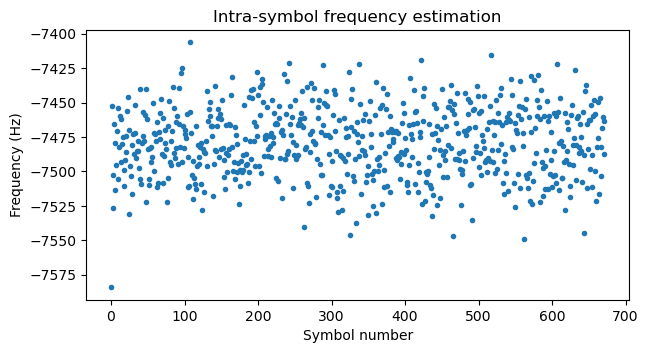

In [14]:
plt.plot(intrasym_freq[:672], '.')
plt.title('Intra-symbol frequency estimation')
plt.xlabel('Symbol number')
plt.ylabel('Frequency (Hz)');

In [15]:
np.average(intrasym_freq[:672])

np.float64(-7479.146510244946)

In [16]:
def demodulate_npusch_single_tone(subframe, num_subframes, subcarrier, npusch_format, find_w_seq=False):
    s = ofdm_syms[14*subframe:14*(subframe+num_subframes), 6 + subcarrier]

    # correct phase rotation for single-tone SC-FDMA (Section 10.1.5 in TS 36.211)
    phase_correction = np.zeros(s.size)
    for j in range(1, phase_correction.size):
        cp_len_ = cp_len2 if j % 7 == 0 else cp_len
        phase_correction[j] = phase_correction[j-1] + 2 * np.pi * 15e3 * (subcarrier + 0.5) * (Tu + cp_len_) / fs
    s = (s.reshape((-1, phase_correction.size)) * np.exp(-1j * phase_correction)).ravel()
    
    if npusch_format == 1:
        # QPSK modulation
        s[1::2] *= np.exp(-1j*np.pi/4)
    elif npusch_format == 2:
        # BPSK modulation
        s[1::2] *= np.exp(-1j*np.pi/2)
    else:
        raise ValueError("unsupported npusch_format")

    if npusch_format == 1:
        ref_idxs = np.arange(s.size)[3::7]
        ref = np.copy(s[ref_idxs])
        ref_seq = 1/np.sqrt(2) * (1 + 1j) * (1 - 2 * c_seq(35, ref.size).astype('float'))
        # TS 36.211 Table 10.1.4.1.1-1 w(1)
        ref_seq[1::2] *= -1
    elif npusch_format == 2:
        ref_idxs = np.arange(s.size).reshape(-1, 7)[:, [2, 3, 4]].ravel()
        ref = np.copy(s[ref_idxs])        
        ref_seq = 1/np.sqrt(2) * (1 + 1j) * (1 - 2 * c_seq(35, ref.size//3).astype('float'))
        # TS 36.211 Table 10.1.4.1.1-1 w(1)
        ref_seq[1::2] *= -1
        ref_seq = np.repeat(ref_seq, 3)
        # NPUSCH format 2
        ref_clean = ref *np.conjugate(ref_seq)
        if find_w_seq:
            # this is computed in terms of NcellID and n_s, which we don't know
            w_seq = np.int32(np.round(np.angle(ref_clean[1::3] * np.conjugate(ref_clean[0::3])) / (2*np.pi/3))) % 3
        else:
            n_s = (2 * subframe + ns1) % 20
            w_seq = np.packbits(c_seq(NcellID, 160).reshape(-1, 8)[:, ::-1]) % 3
            w_seq = np.tile(w_seq, ref.size // (3 * 20) + 2)[n_s:][:ref.size//3]
        ref_seq = ref_seq * np.exp(w_seq[np.arange(ref.size)//3]*1j*2*np.pi/3*(np.arange(ref.size)%3))

    ref *= np.conjugate(ref_seq)
    equal = np.average(ref)
    ref /= equal

    if npusch_format == 1:
        data_idxs = np.arange(s.size).reshape(-1, 7)[:, [0, 1, 2, 4, 5, 6]].ravel()
    elif npusch_format == 2:
        data_idxs = np.arange(s.size).reshape(-1, 7)[:, [0, 1, 5, 6]].ravel()
    data = np.copy(s[data_idxs])
    data /= equal

    plt.figure(figsize=(2.5, 2.5))
    plt.plot(data.real, data.imag, '.', markersize=3)
    plt.plot(ref.real, ref.imag, '.', markersize=3)
    if npusch_format == 1:
        plt.plot(np.array([1, 1, -1, -1, np.sqrt(2)])/np.sqrt(2),
                 np.array([1, -1, 1, -1, 0])/np.sqrt(2), '.',
                 color='red', markersize=2)
    elif npusch_format == 2:
        plt.plot(np.array([1, -1, np.sqrt(2)])/np.sqrt(2),
             np.array([1, -1, 0])/np.sqrt(2), '.',
             color='red', markersize=2)
    plt.xlim((-1.5, 1.5))
    plt.ylim((-1.5, 1.5))
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal', 'box')
    plt.title(f'NPUSCH format {npusch_format} constellation\n'
              f'subframes {subframe} - {subframe+num_subframes}, subcarrier {subcarrier}')
    plt.figure()
    plt.plot(data_idxs, np.angle(data) / (2 * np.pi), '.')
    plt.plot(ref_idxs, np.angle(ref) / (2 * np.pi), '.')
    plt.title(f'NPUSCH format {npusch_format} phases\n'
              f'subframes {subframe} - {subframe+num_subframes}, subcarrier {subcarrier}')
    plt.xlabel('Symbol number')
    plt.ylabel('Phase (cycles)')

    if find_w_seq:
        return data, w_seq
    return data

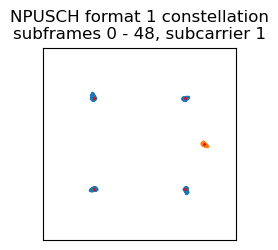

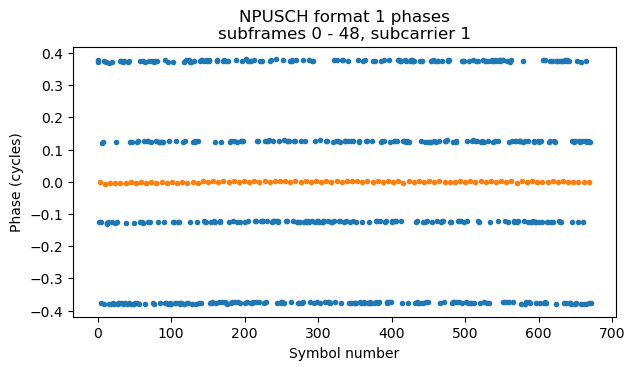

In [17]:
data = demodulate_npusch_single_tone(0, 48, 1, npusch_format=1)

In [18]:
# see below for how these are found
rnti_candidates = [(53958, 1), (55023, 0), (55957, 1), (57020, 0)]
NcellID = 145
assert NcellID % 16 == 1  # w(1) is used
ns0 = 12
slot0 = 2688 // 7

In [19]:
# Table 16.5.1.2-2 in TS 36.213
tbs_table = """0 16 32 56 88 120 152 208 256
1 24 56 88 144 176 208 256 344
2 32 72 144 176 208 256 328 424
3 40 104 176 208 256 328 440 568
4 56 120 208 256 328 408 552 680
5 72 144 224 328 424 504 680 872
6 88 176 256 392 504 600 808 1000
7 104 224 328 472 584 712 1000 1224
8 120 256 392 536 680 808 1096 1384
9 136 296 456 616 776 936 1256 1544
10 144 328 504 680 872 1000 1384 1736
11 176 376 584 776 1000 1192 1608 2024
12 208 440 680 1000 1128 1352 1800 2280
13 224 488 744 1032 1256 1544 2024 2536
14 256 552 840 1128 1416 1736 2280
15 280 600 904 1224 1544 1800 2472
16 328 632 968 1288 1608 1928 2536
17 336 696 1064 1416 1800 2152
18 376 776 1160 1544 1992 2344
19 408 840 1288 1736 2152 2536
20 440 904 1384 1864 2344
21 488 1000 1480 1992 2536"""
tbs_parsed = [[int(n) for n in a.split()] for a in tbs_table.split('\n')]

i_ru_table = [1, 2, 3, 4, 5, 6, 8, 10]
# indexed by (I_TBS, N_RU)
tbs_table = {}
for line in tbs_parsed:
    I_TBS = line[0]
    for I_RU, tbs in enumerate(line[1:]):
        tbs_table[(I_TBS, i_ru_table[I_RU])] = tbs

In [20]:
ns = (ns0 - slot0) % 20
N_RU = 3
syms = -data[:16 * 6 * N_RU].view('float') * np.sqrt(2)
rv = 0
tbs = 88
rnti_candidates_ulsch = []
for n_rnti, n_f0 in rnti_candidates:
    n_f = ((20 * n_f0 + ns0 - slot0) // 20) % 2
    seq = 1 - 2 * c_seq(n_rnti * 2**14 + n_f * 2**13 + (ns // 2) * 2**9 + NcellID, syms.size).astype('float')
    descrambled = syms * seq
    rm = rate_matching_collect_turbo([(np.sign(descrambled), rv)], turbo_len(tbs))
    if np.all([np.all(a[0] == a) for a in rm.values()]):
        rnti_candidates_ulsch.append((n_rnti, n_f))
rnti_candidates_ulsch

[(53958, 0)]

In [21]:
n_rnti = 53958
n_f1 = 0
ns1 = 8

In [22]:
def decode_npusch_format1(data_symbols, ns, rv, tbs, noise_sigma=0.1, constellation=qpsk_constellation, **kwargs):
    llrs = llr_demod(data_symbols.ravel(), noise_sigma, constellation)
    n_f = n_f1 + ns // 20
    seq = 1 - 2 * c_seq(n_rnti * 2**14 + (n_f % 2) * 2**13 + ((ns % 20) // 2) * 2**9 + NcellID, llrs.size).astype('float')
    descrambled = llrs * seq
    bits_per_sym = int(round(np.log2(constellation.size)))
    if len(data_symbols.shape) == 2:
        # multi-tone single RU -> deinterleave
        descrambled = np.einsum('ijk->jik', descrambled.reshape(data_symbols.shape[0], data_symbols.shape[1], bits_per_sym)).ravel()
    elif len(data_symbols.shape) == 3:
        # multi-tone multiple RU -> deinterleave
        descrambled = np.einsum('ijkl->ikjl', descrambled.reshape(
            data_symbols.shape[0], data_symbols.shape[1], data_symbols.shape[2], bits_per_sym)).ravel()
    decode = decode_transport_block([(descrambled, rv)], tbs, **kwargs)
    if decode is not None:
        store_mac_pdu(10 * n_f1 + ns // 2, decode, n_rnti)
    return decode

In [23]:
def annotate_npusch_format1(ns, length_subframes, subcarriers):
    if isinstance(subcarriers, int):
        sc_lo = subcarriers
        sc_hi = subcarriers
    else:
        sc_lo = subcarriers.start
        sc_hi = subcarriers.stop - 1
    f_lo, f_hi = (7.5e3 + sc * 15e3 - delta_f + f_center for sc in (sc_lo, sc_hi))
    f_lo -= 15e3
    f_hi += 15e3
    dataset.add_annotation(round(t_syms[7 * (ns - ns1)] * fs_sigmf), round(length_subframes * 1e-3 * fs_sigmf), metadata = {
        SigMFFile.FLO_KEY: f_lo,
        SigMFFile.FHI_KEY: f_hi,
        #SigMFFile.LABEL_KEY: 'NPUSCH format 1',
        SigMFFile.COMMENT_KEY: 'NPUSCH format 1',
        SigMFFile.GENERATOR_KEY: GENERATOR,
    })

def annotate_npusch_format2(ns, length_subframes, subcarrier, harq_ack):
    f = 7.5e3 + subcarrier * 15e3 - delta_f + f_center
    for j in range(0, length_subframes, 2):
        dataset.add_annotation(round(t_syms[7 * (ns - ns1) + 14 * j] * fs_sigmf),
                               round(2 * 1e-3 * fs_sigmf), metadata = {
            SigMFFile.FLO_KEY: f - 15e3,
            SigMFFile.FHI_KEY: f + 15e3,
            #SigMFFile.LABEL_KEY: 'NPUSCH format 2',
            SigMFFile.COMMENT_KEY: f'NPUSCH format 2\nPositive HARQ ACK = {harq_ack}',
            SigMFFile.GENERATOR_KEY: GENERATOR,
        })

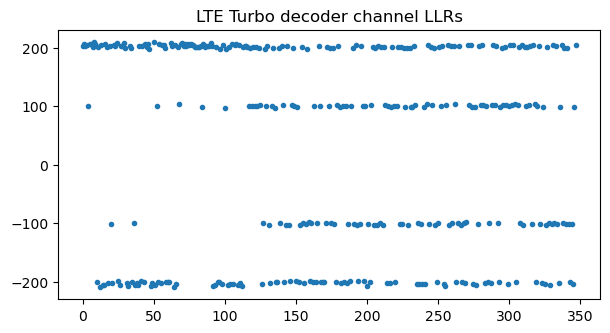

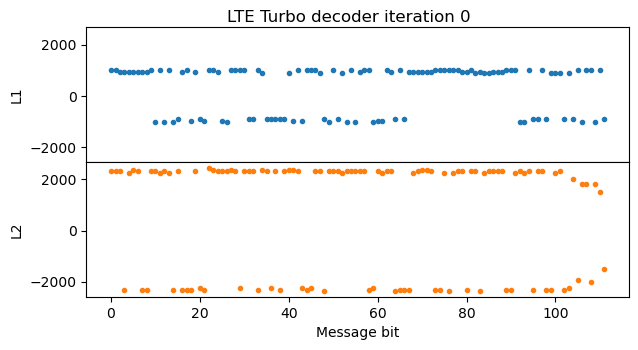

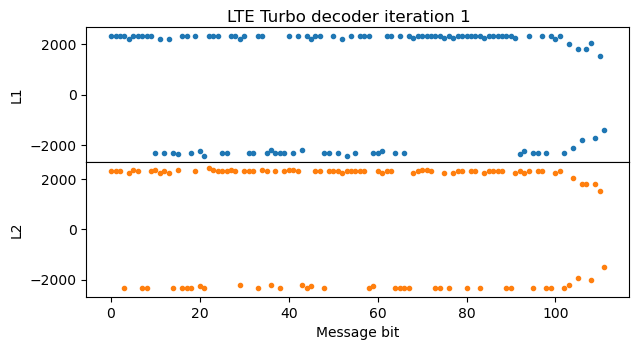

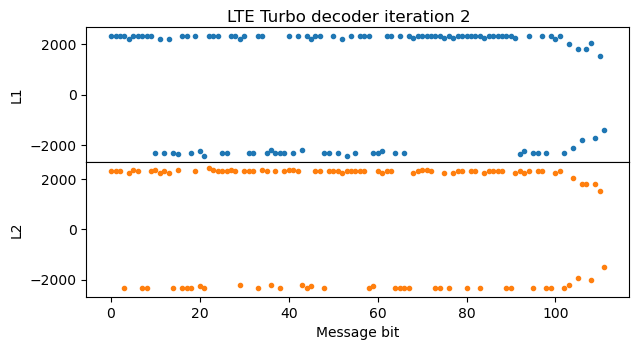

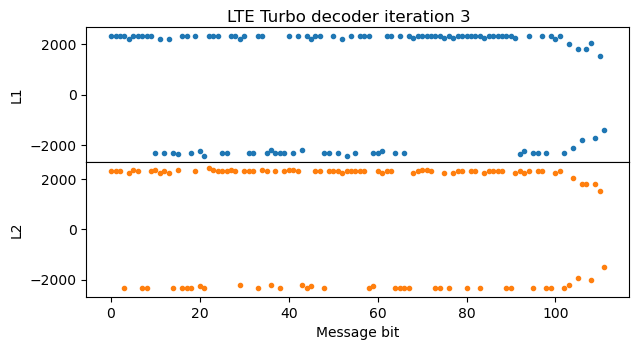

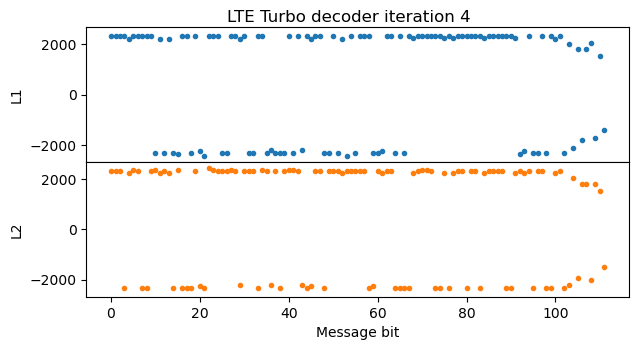

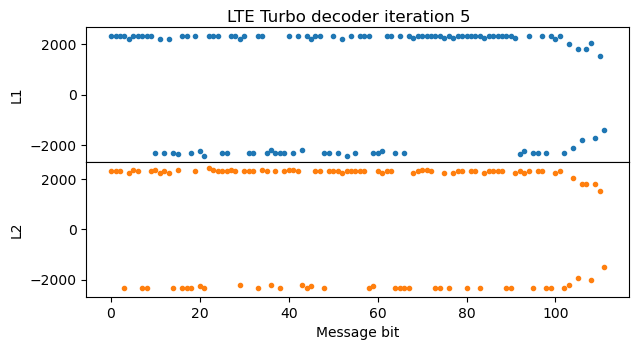

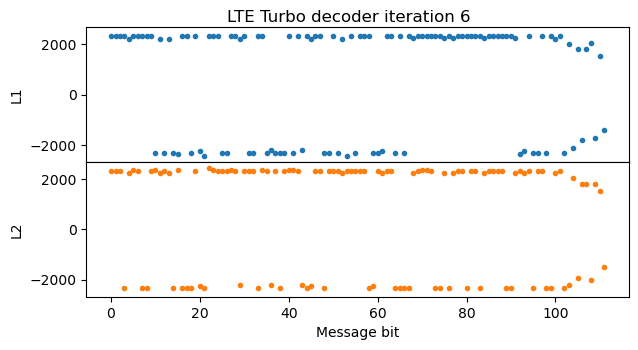

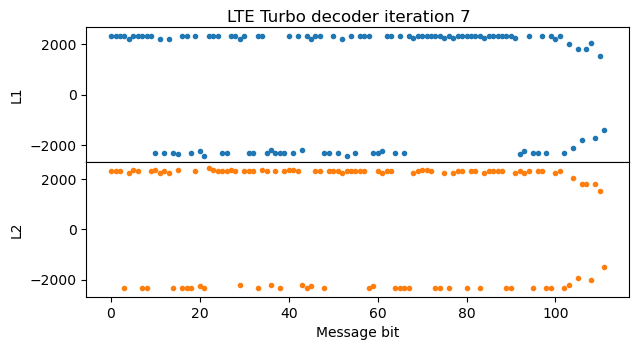

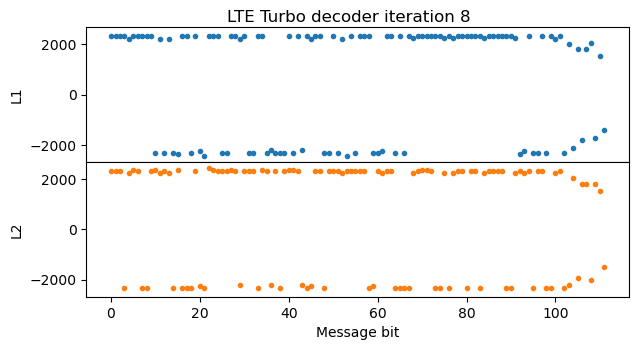

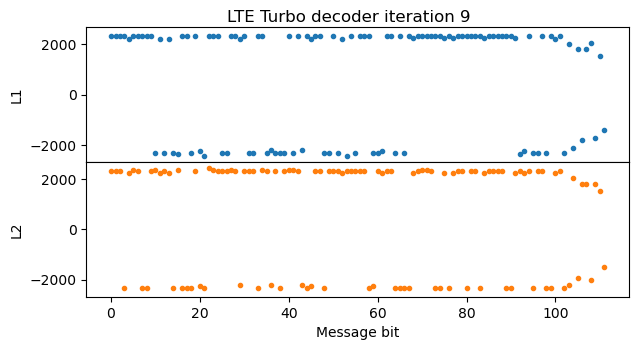

In [24]:
N_RU = 3
tbs = tbs_table[(1, N_RU)]
codewords = data.reshape(-1, 16 * 6 * N_RU)

annotate_npusch_format1(ns1, 8 * N_RU, 1)
d = decode_npusch_format1(codewords[0], ns1, 0, tbs, plot_channel_LLRs=True, do_plots=True)
assert d is not None

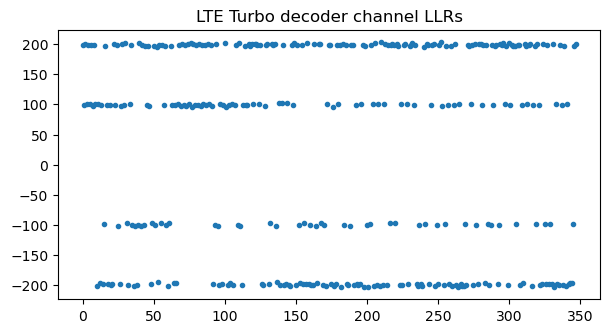

In [25]:
annotate_npusch_format1(ns1 + 16 * N_RU, 8 * N_RU, 1)
d = decode_npusch_format1(codewords[1], ns1 + 16 * N_RU, 2, tbs, plot_channel_LLRs=True)
assert d is not None

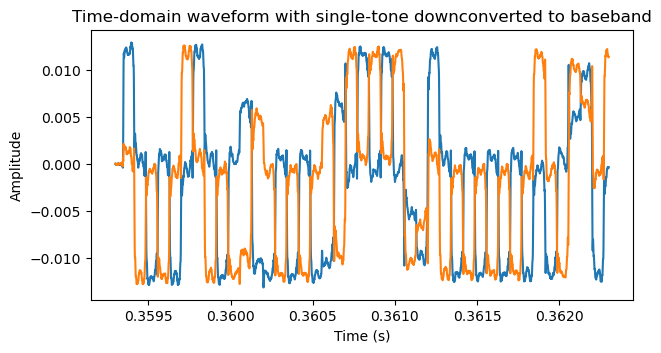

In [26]:
sel = slice(round(0.3593 * fs), round(0.3623 * fs))
y = x[sel] * np.exp(-1j*2*np.pi*(-6 * 15e3 + 7.5e3 - 83.0)/fs*np.arange(x[sel].size))
plt.plot(t_x[sel], y.real)
plt.plot(t_x[sel], y.imag)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time-domain waveform with single-tone downconverted to baseband');

In [27]:
t_syms, ofdm_syms, intrasym_freq = ofdm_demodulate(start_sel.start + 93 - 7, 83.0)

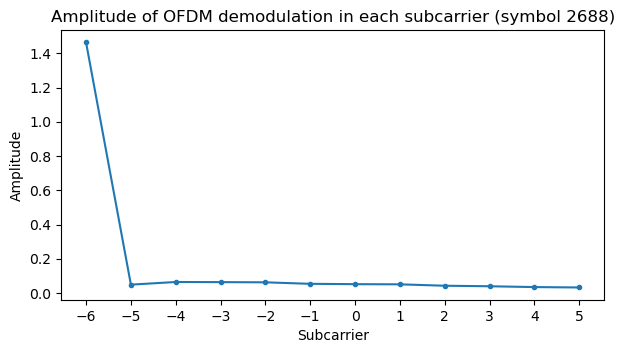

In [28]:
plt.plot(np.arange(-6, 6), np.abs(ofdm_syms[2688]), '.-')
plt.title('Amplitude of OFDM demodulation in each subcarrier (symbol 2688)')
plt.xlabel('Subcarrier')
plt.xticks(np.arange(-6, 6))
plt.ylabel('Amplitude');

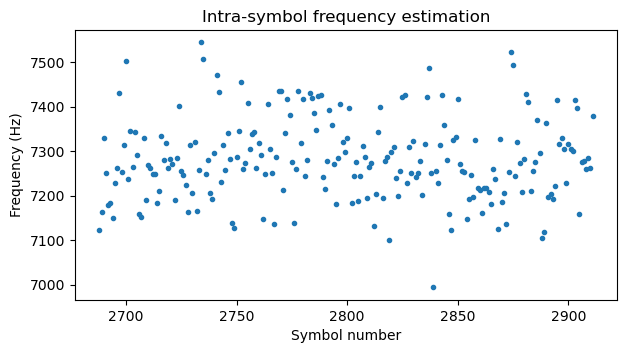

In [29]:
plt.plot(np.arange(2688, 2912), intrasym_freq[2688:2912], '.')
plt.title('Intra-symbol frequency estimation')
plt.xlabel('Symbol number')
plt.ylabel('Frequency (Hz)');

In [30]:
np.std(intrasym_freq[2688:2912])

np.float64(91.72444871517776)

In [31]:
np.average(intrasym_freq[2688:2912])

np.float64(7281.263168244889)

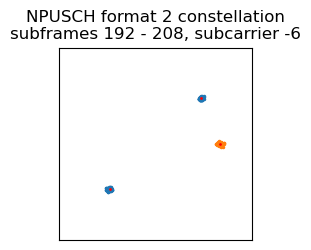

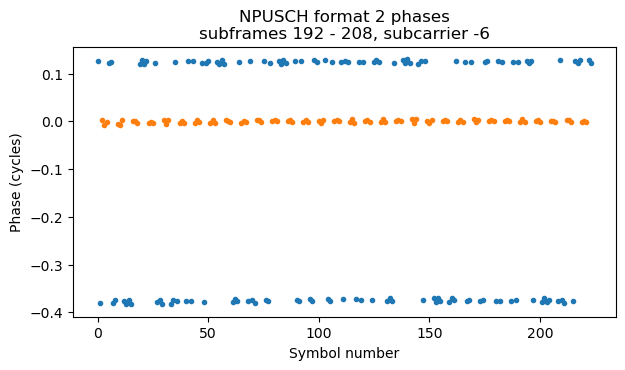

In [32]:
data, w_seq = demodulate_npusch_single_tone(192, 16, -6, npusch_format=2, find_w_seq=True)

In [33]:
w_seq

array([0, 1, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 0, 1,
       2, 2, 0, 2, 1, 0, 2, 2, 2, 2], dtype=int32)

In [34]:
for a in range(20, w_seq.size, 20):
    assert np.all(w_seq[a:a+20] == w_seq[:len(w_seq[a:a+20])])

In [35]:
w_s = "".join([str(s) for s in w_seq[:20]])
NcellID_matches = []
for NcellID in range(504):
    seq = np.packbits(c_seq(NcellID, 160).reshape(-1, 8)[:, ::-1]) % 3
    seq_s = "".join([str(s) for s in seq])
    seq_s2 = seq_s + seq_s
    try:
        ns = seq_s2.index(w_s)
    except ValueError:
        pass
    else:
        NcellID_matches.append((NcellID, ns))
NcellID_matches

[(145, 12)]

In [36]:
NcellID = 145
ns0 = 12

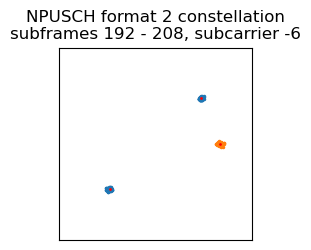

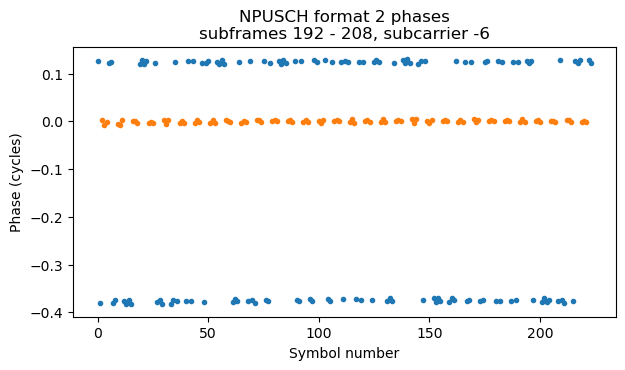

In [37]:
data = demodulate_npusch_single_tone(192, 16, -6, npusch_format=2)

In [38]:
data_bits = (data * np.conjugate(1 + 1j) < 0).astype('int')
candidates = []
for n_rnti in range(2**16):
    for n_f in range(2):
        seq = c_seq(n_rnti * 2**14 + n_f * 2**13 + ns0 // 2 * 2**9 + NcellID, 16)
        descrambled = data_bits[:16] ^ seq
        if np.all(descrambled == descrambled[0]):
            candidates.append((n_rnti, n_f))
candidates

[(53958, 1), (55023, 0), (55957, 1), (57020, 0)]

In [39]:
for n_rnti, n_f in candidates:
    print(f'n_rnti = {bin(n_rnti)}, n_f = {n_f}, c_seq = {c_seq(n_rnti * 2**14 + n_f * 2**13 + ns0 // 2 * 2**9 + NcellID, 16)}')

n_rnti = 0b1101001011000110, n_f = 1, c_seq = [1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0]
n_rnti = 0b1101011011101111, n_f = 0, c_seq = [0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1]
n_rnti = 0b1101101010010101, n_f = 1, c_seq = [0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1]
n_rnti = 0b1101111010111100, n_f = 0, c_seq = [1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0]


In [40]:
for n_rnti, n_f in candidates:
    print(f'n_rnti = {n_rnti}, n_f = {n_f}')
    for offset in range(8):
        seq = c_seq(n_rnti * 2**14 + ((n_f + (ns0 + 4 * offset) // 20) % 2) * 2**13
                    + ((ns0 + 4 * offset) % 20) // 2 * 2**9 + NcellID, 16)
        print(data_bits[16 * offset:][:16] ^ seq)
    print()

n_rnti = 53958, n_f = 1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

n_rnti = 55023, n_f = 0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

n_rnti = 55957, n_f = 1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

n_rnti = 57020, n_f = 0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 

In [41]:
n_rnti = 53958

In [42]:
def descramble_npusch_format2(data_symbols, ns):
    s = np.copy(data_symbols.reshape(-1, 16))
    for j, syms in enumerate(s):
        ns_ = ns + 4 * j
        n_f = n_f1 + ns_ // 20
        seq = 1 - 2 * c_seq(n_rnti * 2**14 + (n_f % 2) * 2**13 + ((ns_ % 20) // 2) * 2**9 + NcellID, 16).astype('float')
        syms *= seq
    plt.plot((s.ravel() * (1 - 1j) / np.sqrt(2)).real, '.')
    plt.ylim(-1.5, 1.5)
    plt.title('Descrambled NPUSCH format 2 transport blocks')
    plt.ylabel('Amplitude')
    plt.xlabel('Data symbol number')

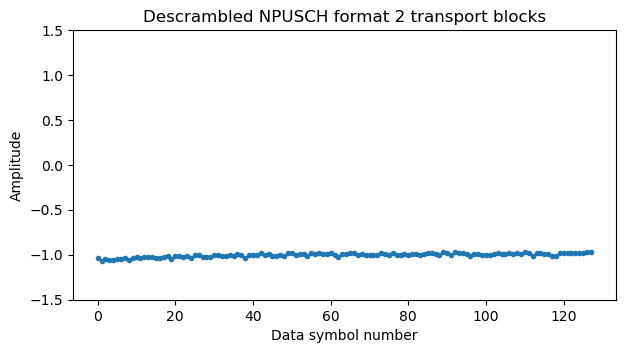

In [43]:
descramble_npusch_format2(data, ns1 + 2 * 192)
annotate_npusch_format2(ns1 + 2 * 192, 16, -6, 1)

In [44]:
t_syms, ofdm_syms, intrasym_freq = ofdm_demodulate(start_sel.start + 93 - 7, 87)

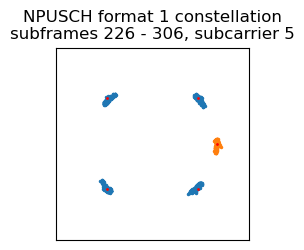

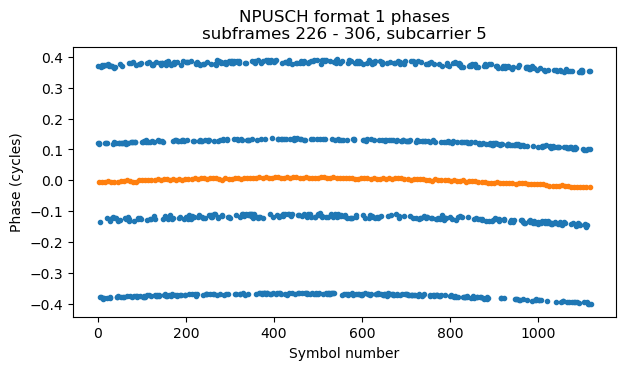

In [45]:
data = demodulate_npusch_single_tone(226, 80, 5, npusch_format=1)

N_RU = 10


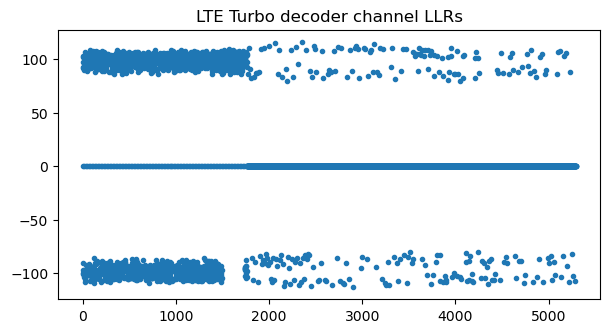

In [46]:
N_RU = data.size // (16 * 6)
print(f'N_RU = {N_RU}')
annotate_npusch_format1(ns1 + 226 * 2, 8 * N_RU, 5)
d = decode_npusch_format1(data, ns1 + 226 * 2, 0, tbs_table[(10, N_RU)], plot_channel_LLRs=True)
assert d is not None

In [47]:
t_syms, ofdm_syms, intrasym_freq = ofdm_demodulate(start_sel.start + 93 - 7, 97)

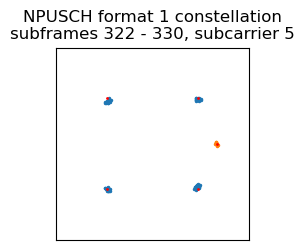

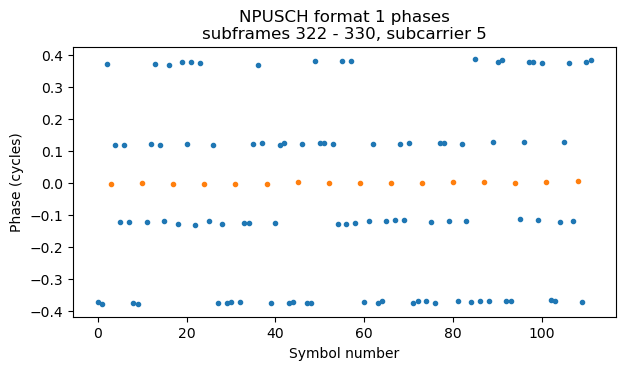

In [48]:
data = demodulate_npusch_single_tone(322, 8, 5, npusch_format=1)

N_RU = 1


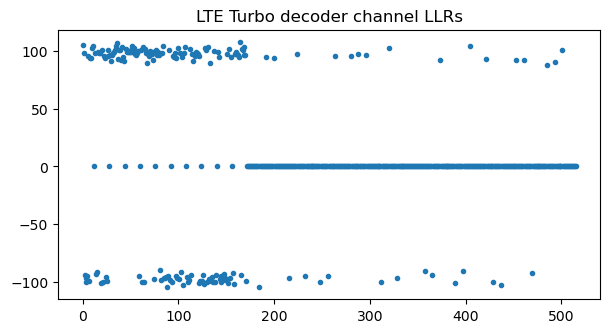

In [49]:
N_RU = data.size // (16 * 6)
print(f'N_RU = {N_RU}')
annotate_npusch_format1(ns1 + 322 * 2, 8 * N_RU, 5)
d = decode_npusch_format1(data, ns1 + 322 * 2, 0, tbs_table[(10, N_RU)], plot_channel_LLRs=True)
assert d is not None

In [50]:
# Table 10.1.4.1.2-1 from TS 36.211
phi_n_ru_sc_3 = np.array([
    [1, -3, -3],
    [1, -3, -1],
    [1, -3, 3],
    [1, -1, -1],
    [1, -1, 1],
    [1, -1, 3],
    [1, 1, -3],
    [1, 1, -1],
    [1, 1, 3],
    [1, 3, -1],
    [1, 3, 1],
    [1, 3, 3],
])

# Table 10.1.4.1.2-2 from TS 36.211
phi_n_ru_sc_6 = np.array([
    [1, 1, 1, 1, 3, -3],
    [1, 1, 3, 1, -3, 3],
    [1, -1, -1, -1, 1, -3],
    [1, -1, 3, -3, -1, -1],
    [1, 3, 1, -1, -1, 3],
    [1, -3, -3, 1, 3, 1],
    [-1, -1, 1, -3, -3, -1],
    [-1, -1, -1, 3, -3, -1],
    [3, -1, 1, -3, -3, 3],
    [3, -1, 3, -3, -1, 1],
    [3, -3, 3, -1, 3, 3],
    [-3, 1, 3, 1, -3, -1],
    [-3, 1, -3, 3, -3, -1],
    [-3, 3, -3, 1, 1, -3],
])

# Table 5.5.1.2-1 from TS 36.211
tstab = """0 -1 1 3 -3 3 3 1 1 3 1 -3 3
1 1 1 3 3 3 -1 1 -3 -3 1 -3 3
2 1 1 -3 -3 -3 -1 -3 -3 1 -3 1 -1
3 -1 1 1 1 1 -1 -3 -3 1 -3 3 -1
4 -1 3 1 -1 1 -1 -3 -1 1 -1 1 3
5 1 -3 3 -1 -1 1 1 -1 -1 3 -3 1
6 -1 3 -3 -3 -3 3 1 -1 3 3 -3 1
7 -3 -1 -1 -1 1 -3 3 -1 1 -3 3 1
8 1 -3 3 1 -1 -1 -1 1 1 3 -1 1
9 1 -3 -1 3 3 -1 -3 1 1 1 1 1
10 -1 3 -1 1 1 -3 -3 -1 -3 -3 3 -1
11 3 1 -1 -1 3 3 -3 1 3 1 3 3
12 1 -3 1 1 -3 1 1 1 -3 -3 -3 1
13 3 3 -3 3 -3 1 1 3 -1 -3 3 3
14 -3 1 -1 -3 -1 3 1 3 3 3 -1 1
15 3 -1 1 -3 -1 -1 1 1 3 1 -1 -3
16 1 3 1 -1 1 3 3 3 -1 -1 3 -1
17 -3 1 1 3 -3 3 -3 -3 3 1 3 -1
18 -3 3 1 1 -3 1 -3 -3 -1 -1 1 -3
19 -1 3 1 3 1 -1 -1 3 -3 -1 -3 -1
20 -1 -3 1 1 1 1 3 1 -1 1 -3 -1
21 -1 3 -1 1 -3 -3 -3 -3 -3 1 -1 -3
22 1 1 -3 -3 -3 -3 -1 3 -3 1 -3 3
23 1 1 -1 -3 -1 -3 1 -1 1 3 -1 1
24 1 1 3 1 3 3 -1 1 -1 -3 -3 1
25 1 -3 3 3 1 3 3 1 -3 -1 -1 3
26 1 3 -3 -3 3 -3 1 -1 -1 3 -1 -3
27 -3 -1 -3 -1 -3 3 1 -1 1 3 -3 -3
28 -1 3 -3 3 -1 3 3 -3 3 3 -1 -1
29 3 -3 -3 -1 -1 -3 -1 3 -3 3 1 -1"""
tstab = [[int(a) for a in line.split()[1:]] for line in tstab.split('\n')]
phi_n_ru_sc_12 = np.array(tstab)

In [51]:
def demodulate_npusch_multitone(subframe, num_subframes, subcarriers):
    s = ofdm_syms[14*subframe:14*(subframe+num_subframes), subcarriers.start+6:subcarriers.stop+6]
    N_sc_RU = subcarriers.stop - subcarriers.start

    # Section 10.1.4.1.2 in TS 36.211
    alpha = 0
    if N_sc_RU == 3:
        phi_table = phi_n_ru_sc_3
        u = NcellID % 12
    elif N_sc_RU == 6:
        phi_table = phi_n_ru_sc_6
        u = NcellID % 14
    elif N_sc_RU == 12:
        phi_table = phi_n_ru_sc_12
        u = NcellID % 30
    else:
        raise ValueError("unsupported N_sc_RU")
    ru = np.exp(1j * alpha * np.arange(N_sc_RU)) * np.exp(1j * phi_table[u] * np.pi / 4)        
    ref_idxs = np.arange(s.shape[0])[3::7]
    ref = s[ref_idxs] * np.conjugate(ru)
    equal = np.average(ref)
    ref /= equal

    data_idxs = np.arange(s.shape[0]).reshape(-1, 7)[:, [0, 1, 2, 4, 5, 6]].ravel()
    data = np.fft.ifft(s[data_idxs] / equal) * np.sqrt(N_sc_RU)

    plt.figure(figsize=(2.5, 2.5))
    plt.plot(data.real, data.imag, '.', markersize=3, color='C0')
    plt.plot(ref.real, ref.imag, '.', markersize=3, color='C1')
    plt.plot(np.array([1, 1, -1, -1, np.sqrt(2)])/np.sqrt(2),
             np.array([1, -1, 1, -1, 0])/np.sqrt(2), '.',
                 color='red', markersize=2)
    plt.xlim((-1.5, 1.5))
    plt.ylim((-1.5, 1.5))
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal', 'box')
    plt.title(f'NPUSCH multi-tone constellation\n'
              f'subframes {subframe} - {subframe+num_subframes}, subcarriers {subcarriers.start} - {subcarriers.stop}')
    plt.figure()
    plt.plot(data_idxs, np.angle(data) / (2 * np.pi), '.', color='C0')
    plt.plot(ref_idxs, np.angle(ref) / (2 * np.pi), '.', color='C1')
    plt.title(f'NPUSCH multi-tone phases\n'
              f'subframes {subframe} - {subframe+num_subframes}, subcarriers {subcarriers.start} - {subcarriers.stop}')
    plt.xlabel('Symbol number')
    plt.ylabel('Phase (cycles)')

    return data

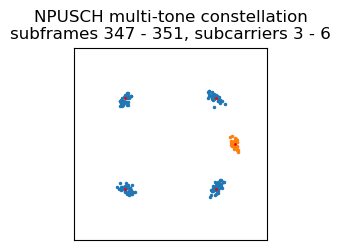

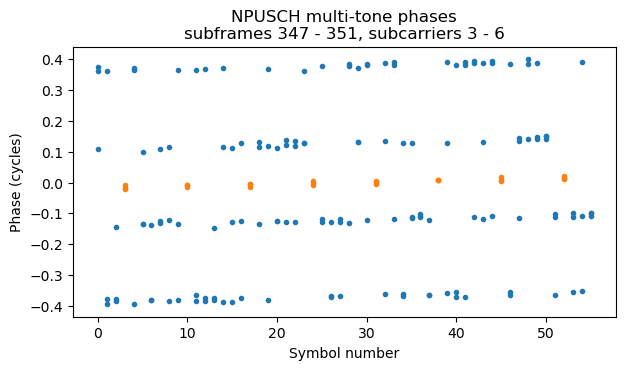

In [52]:
data = demodulate_npusch_multitone(347, 4, slice(3, 6))

In [53]:
N_RU = 1
I_TBS = 13
annotate_npusch_format1(ns1 + 347 * 2, 4, slice(3, 6))
d = decode_npusch_format1(data, ns1 + 347 * 2, 0, tbs_table[(I_TBS, N_RU)])
assert d is not None

In [54]:
t_syms, ofdm_syms, intrasym_freq = ofdm_demodulate(start_sel.start + 93 - 7, 90)

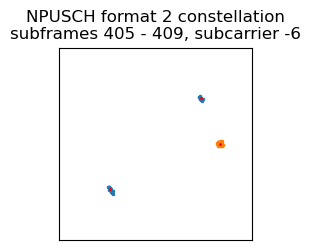

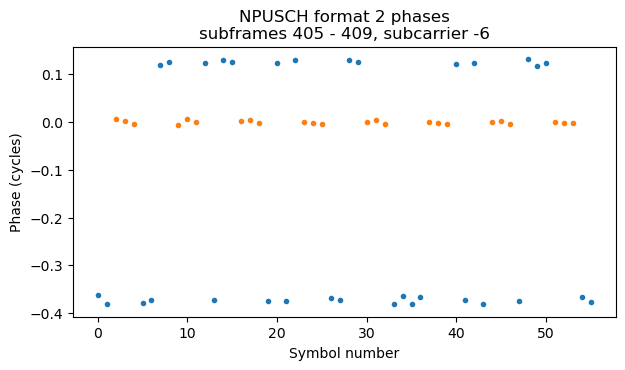

In [55]:
data = demodulate_npusch_single_tone(405, 4, -6, npusch_format=2)

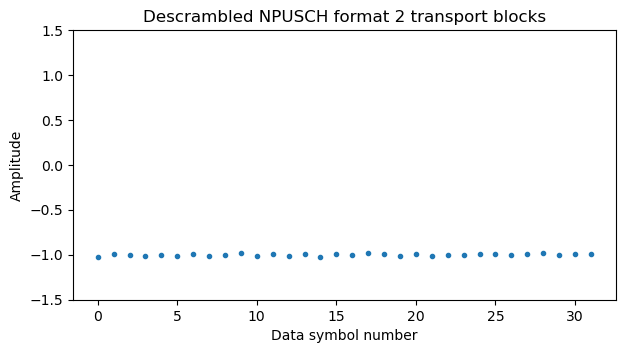

In [56]:
descramble_npusch_format2(data, ns1 + 2 * 405)
annotate_npusch_format2(ns1 + 2 * 405, 4, -6, 1)

In [57]:
t_syms, ofdm_syms, intrasym_freq = ofdm_demodulate(start_sel.start + 93 - 8, 90)

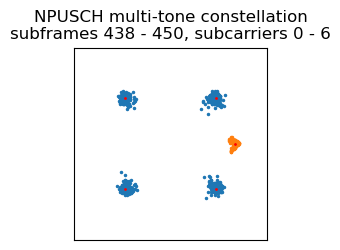

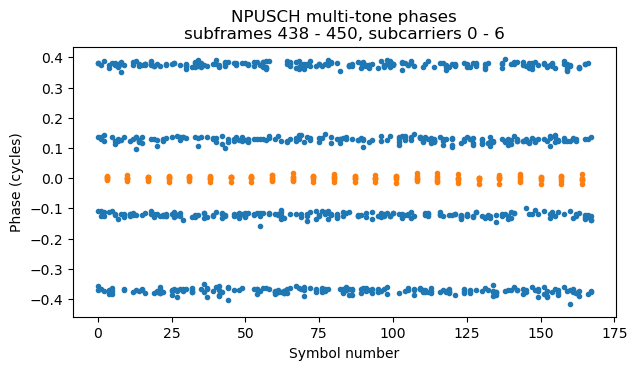

In [58]:
data = demodulate_npusch_multitone(438, 12, slice(0, 6))

In [59]:
N_RU = 6
I_TBS = 13
annotate_npusch_format1(ns1 + 438 * 2, 2 * N_RU, slice(0, 6))
d = decode_npusch_format1(data.reshape(N_RU, 4 * 6, 6), ns1 + 438 * 2, 0, tbs_table[(I_TBS, N_RU)])
assert d is not None

In [60]:
t_syms, ofdm_syms, intrasym_freq = ofdm_demodulate(start_sel.start + 93 - 8, 100)

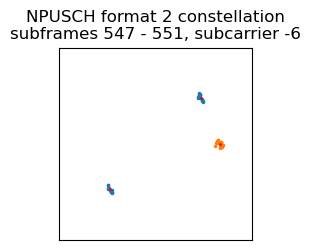

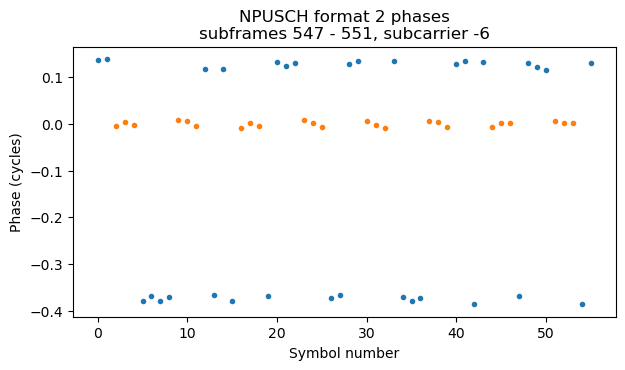

In [61]:
data = demodulate_npusch_single_tone(547, 4, -6, npusch_format=2)

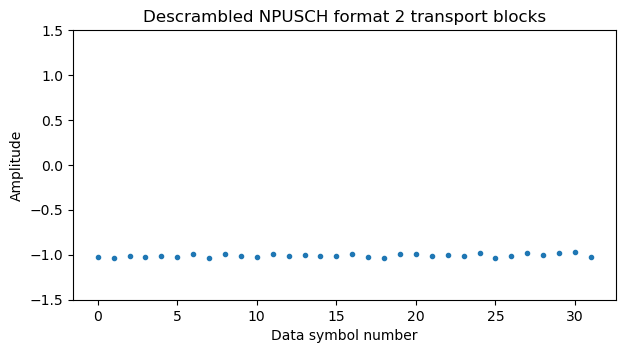

In [62]:
descramble_npusch_format2(data, ns1 + 2 * 547)
annotate_npusch_format2(ns1 + 2 * 547, 4, -6, 1)

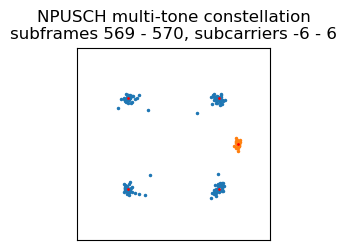

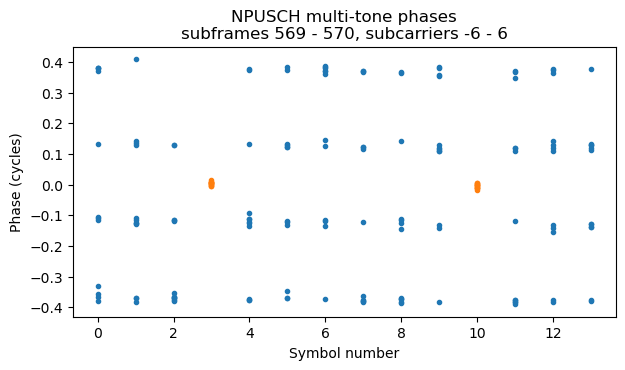

In [63]:
t_syms, ofdm_syms, intrasym_freq = ofdm_demodulate(start_sel.start + 93 - 12, 90)
data = demodulate_npusch_multitone(569, 1, slice(-6, 6))

In [64]:
N_RU = 1
I_TBS = 13
annotate_npusch_format1(ns1 + 569 * 2, 1, slice(-6, 6))
d = decode_npusch_format1(data, ns1 + 569 * 2, 0, tbs_table[(I_TBS, N_RU)])
assert d is not None

In [65]:
# Save generated annotations
dataset.tofile(dataset_path)

In [66]:
# Save wireshark pcap
wireshark_udp_packets.sort(key=lambda packet: packet.time)
scapy.utils.wrpcap('V16-beacon-uplink.pcap', wireshark_udp_packets)